<div style="background: lightpink; color:darkmagenta; font-size: 20px; padding: 10px; border: 1px solid lightgray; margin: 10px;">
  &#9432;
<font color='red'>
Work-in-progress!</font>
<br><p style="font-size: 15px;">
This tutorial gives an overview of how to use the so called `mmotifs` function in order to find many repeating structures in multi-dimensional time series data. Unfortunately a suboptimal data set was chosen for the demonstration of this function. Since the data set needed a lot of preprocessing, we weren't able to find meaningful motifs all the time. This problem may be tackled in a future pull request while discovering another data set.
</p></div>

# Top-K Multi-Dimensional Motif and Matches Discovery

This tutorial builds on the [Multidimensional Motif Discovery](https://stumpy.readthedocs.io/en/latest/Tutorial_Multidimensional_Motif_Discovery.html) tutorial as it generalizes the search for a single multidimensional motif to multiple multidimensional motifs and their nearest neighbors (i.e. matches). We will show how the function `mmotifs`, which extends this advanced motif and match search, works by setting and explaining the different input parameters. The `mmotifs` function is the multidimensional analogue of the one-dimensional [motifs](https://github.com/TDAmeritrade/stumpy/blob/main/stumpy/motifs.py) function that can be found in the STUMPY API. In doing so, the function uses the MDL approach inside it to calculate the number of relevant dimensions unsupervised and return those dimensions while computing the subspace.

Note that the following function is only used to visualize all the motifs and matches that we will find.

In [1]:
def show_motifs_matches(df, motifs_distances, motifs_indices, motifs_subspaces, motifs_mdls):
    num_motifs = motifs_distances.shape[0]

    for motif_num in range(num_motifs):
        motif_indices = motifs_indices[motif_num]
        S = motifs_subspaces[motif_num]

        k = len(S)
        f, axs = plt.subplots(k, 1, figsize=(20, 10), sharex=True)
        plt.suptitle(f"The {motif_num + 1}. {k}-dimensional motif")

        for j, s in enumerate(S):
            time_series = df[df.columns[s]]
            if k > 1:
                ax = axs[j]
            else:
                ax = axs
            ax.plot(time_series, c="0.75")
            ax.set_title(df.columns.values[s])

            motif_idx = motif_indices[0]
            nn_idx = motif_indices[1]
            ax.plot(time_series[motif_idx : motif_idx + m], c="r", linewidth=4)
            ax.plot(time_series[nn_idx : nn_idx + m], c="r", linewidth=4)

            # Only relevant if you want to find further matches
            # Set motif_indices[2:] to avoid double counting the motif pair
            [ax.plot(time_series[match : match + m], linewidth=3) for match in motif_indices[2:]]


## Getting started

Let's import the packages that we will need to load, analyze, and plot the data.

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import stumpy

plt.style.use(
    "https://raw.githubusercontent.com/TDAmeritrade/stumpy/main/docs/stumpy.mplstyle"
)

## Loading, Preprocessing and Visualizing the Dataset

In the following we will take a look at the [Electrical Load Measurement](https://pureportal.strath.ac.uk/en/datasets/refit-electrical-load-measurements-cleaned) dataset, that consists of electrical load measurements for different appliances from households in the UK. To reduce the amount of data somewhat, we consider only one household in the period from april 19 to may 15 of the year 2014. Also we want to take a closer look at only the five appliances `Fridge-Freezer`, `Freezer`, `Tumble Dryer`, `Diswasher` and `Washing Machine` and see if we are able to find meaningful motifs and matches on this multidimensional time series data! We simplify our life a bit more by converting the timestamps, which are sampled to 8 second intervals, to minutes in order to reduce the overall data size:

In [3]:
start_date, end_date = "2014-04-19", "2014-05-15"
raw_df = pd.read_csv("../CLEAN_House3.csv")
raw_df["Time"] = pd.to_datetime(raw_df["Time"])
colnames = {
    "Appliance1": "Toaster",
    "Appliance2": "Fridge-Freezer",
    "Appliance3": "Freezer",
    "Appliance4": "Tumble Dryer",
    "Appliance5": "Dishwasher",
    "Appliance6": "Washing Machine",
    "Appliance7": "Television",
    "Appliance8": "Microwave",
    "Appliance9": "Kettle",
}
raw_df = (
    raw_df.rename(colnames, axis="columns")
    .loc[
        :,
        [
            "Time",
            "Fridge-Freezer",
            "Freezer",
            "Tumble Dryer",
            "Dishwasher",
            "Washing Machine",
        ],
    ]
    .query("Time >= @start_date and Time <= @end_date")
    .groupby(pd.Grouper(key="Time", freq="T"))
    .sum().astype(float)
)

raw_df.head()

,Fridge-Freezer,Freezer,Tumble Dryer,Dishwasher,Washing Machine
Time,,,,,
2014-04-19 00:00:00,0.0,0.0,0.0,0.0,0.0
2014-04-19 00:01:00,0.0,0.0,0.0,0.0,0.0
2014-04-19 00:02:00,0.0,0.0,0.0,0.0,0.0
2014-04-19 00:03:00,0.0,0.0,0.0,0.0,0.0
2014-04-19 00:04:00,0.0,0.0,0.0,0.0,0.0


Now our dataset contains the time series of the five appliances with timestamps now sampled in minutes. Let's visualize it!

![fridge freezer](https://upload.wikimedia.org/wikipedia/commons/thumb/2/25/Bosch_Electronic_no_frost_fridge_freezer_%282019%29_05.jpg/135px-Bosch_Electronic_no_frost_fridge_freezer_%282019%29_05.jpg)
![freezer](https://upload.wikimedia.org/wikipedia/commons/thumb/6/6e/Helio_House_%288800481437%29.jpg/320px-Helio_House_%288800481437%29.jpg)
![dishwasher](https://upload.wikimedia.org/wikipedia/commons/thumb/8/82/Dishwasher_open_for_loading.jpg/180px-Dishwasher_open_for_loading.jpg)
![Washing Machine and Tumble Dryer](https://upload.wikimedia.org/wikipedia/commons/thumb/8/84/Samsung%2C_IFA_2018%2C_Berlin_%28P1070290%29.jpg/320px-Samsung%2C_IFA_2018%2C_Berlin_%28P1070290%29.jpg)

Ok, now that we've marveled at those beautifully visualized household appliances we're ready to visualize those timeseries as well.

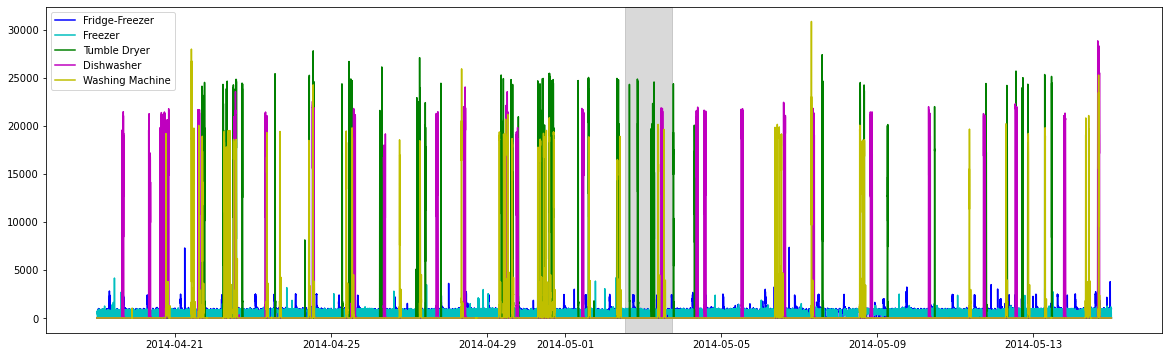

In [4]:
color_list = ['b', 'c', 'g', 'm', 'y']
for i, colname in enumerate(raw_df.columns):
    plt.plot(raw_df[colname], label=colname, color=color_list[i])
plt.legend()
plt.axvspan('2014-05-02 13:00:00','2014-05-03 18:00:00',color='black',alpha=0.15)
plt.show()

Let us zoom in on a typical afternoon, to get a better feel for this large dataset!

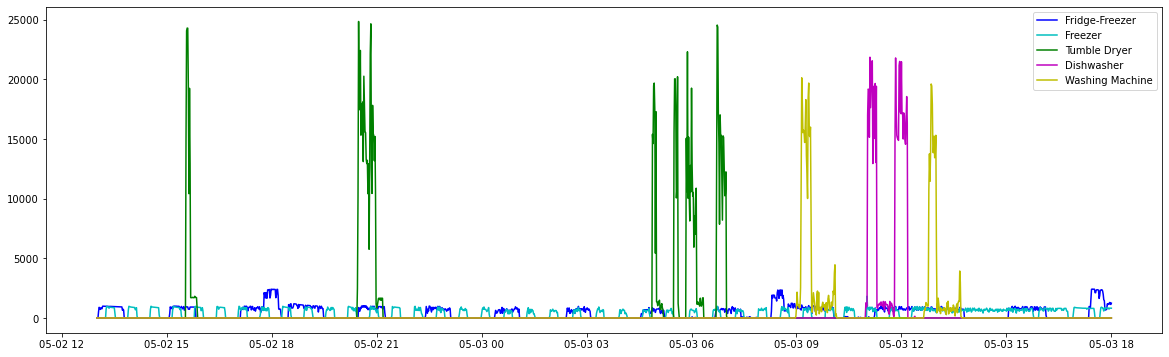

In [5]:
zoom = raw_df.query("Time >= '2014-05-02 13:00:00' and Time <= '2014-05-03 18:00:00'")

for i, colname in enumerate(zoom.columns):
    plt.plot(zoom[colname], label=colname, color=color_list[i])
    plt.legend()

On this day you can clearly see two spikes resulting from the dishwasher usage of one household.
Now let us try to find the most similar patterns across our large dataset spanning four hours within the extracted month.

In [6]:
# m was set to 4 hours
m = 4 * 60
df = raw_df.copy()

Before we are able to find motifs and matches with the `mmotifs` function, we first have to compute the mutli-dimensional matrix profile.

But notice: Each row of the resultung array corresponds to each matrix profile for a given dimension, as shown below.

|Array|
|:-----:|
|_1D Matrix Profile_ $...$ |
|_2D Matrix Profile_ $...$ |
| $\vdots$ |
|_5D Matrix Profile_ $...$ |

Therefore the dimensionality of our last row contains the nearest neighbor information of all 5 appliances. In contrast the 3D matrix profile contains the same information but only for three out of the five appliances. But the matrix profile doesn't tell us which of those dimensions are relevant. This information can only be found within the matrix profile subspace, which is one of the return values of the `mmotifs` function.

We compute the multi-dimensional matrix profile and its indices just like in the [multidimensional motif discovery tutorial](https://stumpy.readthedocs.io/en/latest/Tutorial_Multidimensional_Motif_Discovery.html) as follows:

In [7]:
mps, indices = stumpy.mstump(df, m)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


## Annotation Vectors

Unfortunately we first have to eliminate constant regions in order to find meaningful motifs. Otherwise we would only find the areas where no appliances are used and therefore the electrical power demand is constantly 0. This would be a very strong but meaningless motif. To avoid this problem we use the so called `Annotation Vector` approach which was already introduced in the [Guided Motif Search With Annotation Vectors](https://stumpy.readthedocs.io/en/latest/Tutorial_Annotation_Vectors.html) tutorial in the one-dimensional case. According to this approach it will be possible to re-rank candidate motifs by producing a vector that is "parallel" to the original time series and annotates it with the user's constraints to allow a more meaningful motif discovery.

In order to apply the `Annotation Vector` approach to the multi-dimensional case we have to first iterate over all possible dimensions.<br>
<u>Remember:</u><br>
The Annotation Vector is a time series consisting of real-valued numbers between 0 and 1. A low value indicates that the corresponding subsequence is not a desirable motif. Likewise, a high value means that the subsequence should get more attention in the motif discovery process.<br>
Afterwards we have to check which subsequences should get a higher and which a lower rank:

In [8]:
annotation_vector = np.ones(mps.shape, dtype=np.float64)

for k in range(mps.shape[0]):
    for subseq_idx in range(mps.shape[1]):
        nn_idx = indices[k, subseq_idx]
        S = stumpy.subspace(df, m, subseq_idx, nn_idx, k)
        if np.count_nonzero(df.iloc[subseq_idx:subseq_idx+m, S]) <= (len(S) * m)//2 or np.count_nonzero(df.iloc[nn_idx:nn_idx+m, S]) <= (len(S) * m)//2:
            annotation_vector[k, subseq_idx] = 0.0

The code above creates the Annotation Vector that is initialized with `ones` spanning the length of the first line in the matrix profile.
Then, for each dimension, we find the motif/nearest neighbor subsequence pair and determine the optimal subspace as described in the [Multidimensional Motif Discovery](https://stumpy.readthedocs.io/en/latest/Tutorial_Multidimensional_Motif_Discovery.html) tutorial. Using the `if` condition we count the number of non-zero elements within the multidimensional subsequences that span the motif pair. If more than half of the values that make up these subsequences (the motif or nearest neighbor) are zero, then we set the Annotation Vector value to zero. This means that such areas are considered uninteresting and can therefore no longer be found as a motif. All in all we are trying to focus on motif pairs that have enough real, non-zero values to allow for a meaningful motif discovery using this dataset.

Then, we can use the newly created Annotation Vector to generate a corrected multidimensional matrix profile:

In [9]:
corrected_mps = mps + ((1.0 - annotation_vector) * np.max(mps))

## Discovering one motif and its matches

Once we have computed the corrected multidimensional matrix profile, we are able to search for recurring structures in our multivariate time series. So let us find out how `mmotifs` works by passing specific parameters to this function and discover different motifs and matches along the way. For this we should first understand the outputs that we get from the function:

`motifs_distances`: This array holds the distances corresponding to a set of subsequence matches for each motif. The first column always corresponds to the distance of the self-match for each motif. <br>
`motifs_indices`: This array holds the indices corresponding to a set of subsequence matches for each motif. Just as with the distances, the first column of the indices is for the self-match for each motif. <br>
`motifs_subspaces`: This list contains the `k`-dimensional subspace for each motif which tells us in which time series dimensions the motifs are located.<br>
`motifs_mdls`: This list contains the MDL-results for finding the dimension of each motif. Given this list, we are able to understand why the motifs are found in exactly that many dimensions when doing an unconstrained search. 

This outputs consist of as many rows as motifs are found. The `motifs_distances` and `motifs_indices` contain the multi-dimensional motif pair for each found motif and all other columns contain the subsequences most similar to the motif, ordered by size (smaller distance meaning more similarity).

So let us do a completely unconstrained search at first and call `mmotifs` with default parameters! In this case you only have to pass the already computed multi-dimensional distance profile together with its indices to the function. Of course, the multidimensional time series or sequence in which the motifs are to be found must not be missing either! Accordingly, the simplest function call is as follows:

In [10]:
motifs_distances, motifs_indices, motifs_subspaces, motifs_mdls = stumpy.mmotifs(
    df, corrected_mps, indices
)

And of course, we can visualize the results we found with the already defined `show_motifs_matches` function.

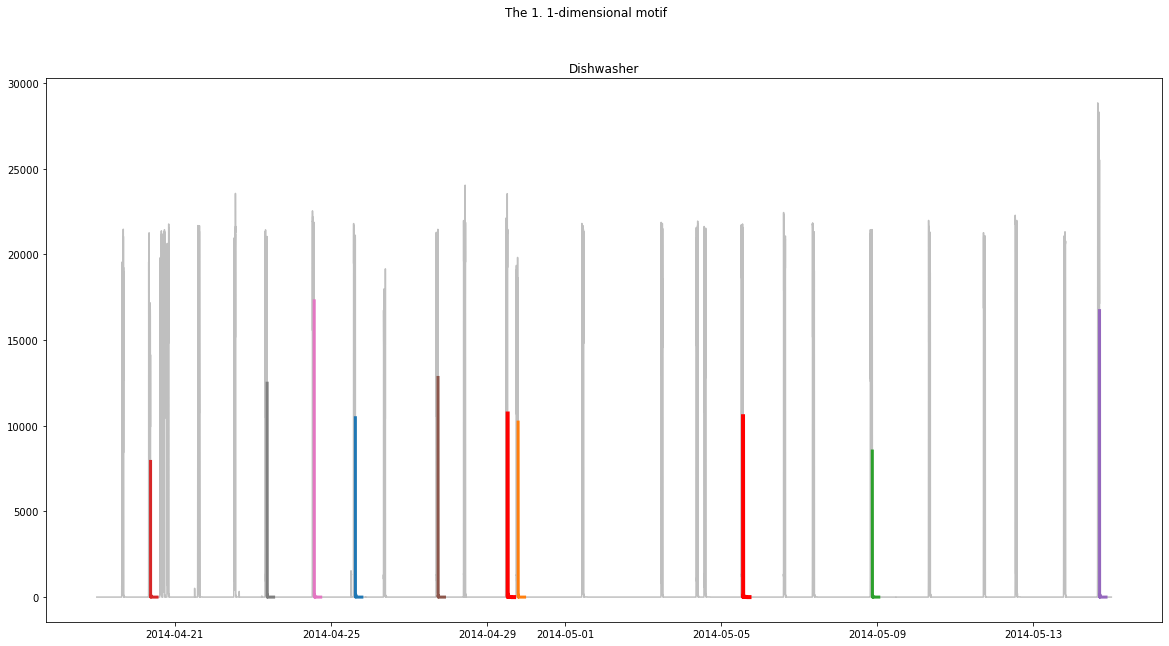

In [11]:
show_motifs_matches(df, motifs_distances, motifs_indices, motifs_subspaces, motifs_mdls)

Congratulations, you have found your first motif on the `Dishwasher` time series! We were able to find all 10 default matches with the motif pair (i. e. the two most similar subsequences) shown in red! 

But this doesn't always have to be the case since the `max_distance` input parameter is computed automatically depending on the distance profile if not explicitly set otherwise. Therefore in this case the `max_distance` parameter was bigger than all of the distances from the motif to its nine nearest neighbors and that's the reason why we were able to find all ten `max_matches`. The `max_matches` input parameter (which is set to 10 by default) is the maximum amount of similar matches (i.e. nearest neighbors) of a representative motif to be returned. But again, notice that the first match is always the self-match for each motif!

Let's plot our discovered matches on top of each other to see how similar they are!

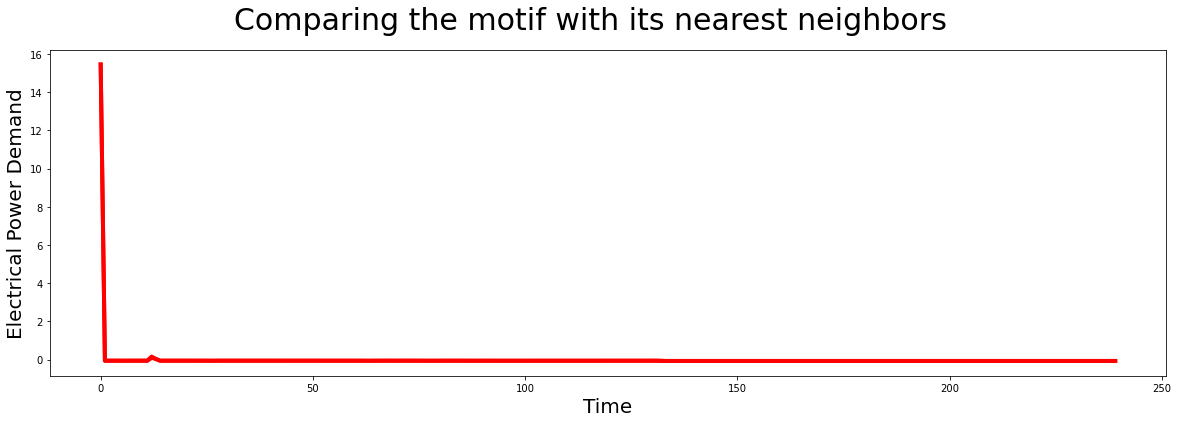

In [12]:
num_motifs = motifs_distances.shape[0]

for motif_num in range(num_motifs):
    motif_indices = motifs_indices[motif_num]
    subspace_num = motifs_subspaces[motif_num]
    subspace_names = [df.columns.values[s] for s in subspace_num]

    figure, ax = plt.subplots(len(subspace_num), 1)
    plt.suptitle('Comparing the motif with its nearest neighbors', fontsize='30')
    plt.xlabel('Time', fontsize ='20')
    plt.ylabel('Electrical Power Demand', fontsize='20') 
    
    for i, match_index in reversed(list(enumerate(motif_indices))):
        match_z_norm = stumpy.core.z_norm(df[subspace_names].values[match_index: match_index + m])
        if i < 2:
            # Motif pair
            ax.plot(match_z_norm, lw=4, color='red')
        else:
            # Other neighbors
            ax.plot(match_z_norm, lw=2)

    plt.show()


As you can see, the found matches are very similar to each other. Only when you zoom in very close into the plot, you can see small differences between the individual subsequences.

What if we only want to get the motif pair without any further matches? That's easy! Simply specifiy that you want to find two matches by setting `max_matches=2` and plot everything again:

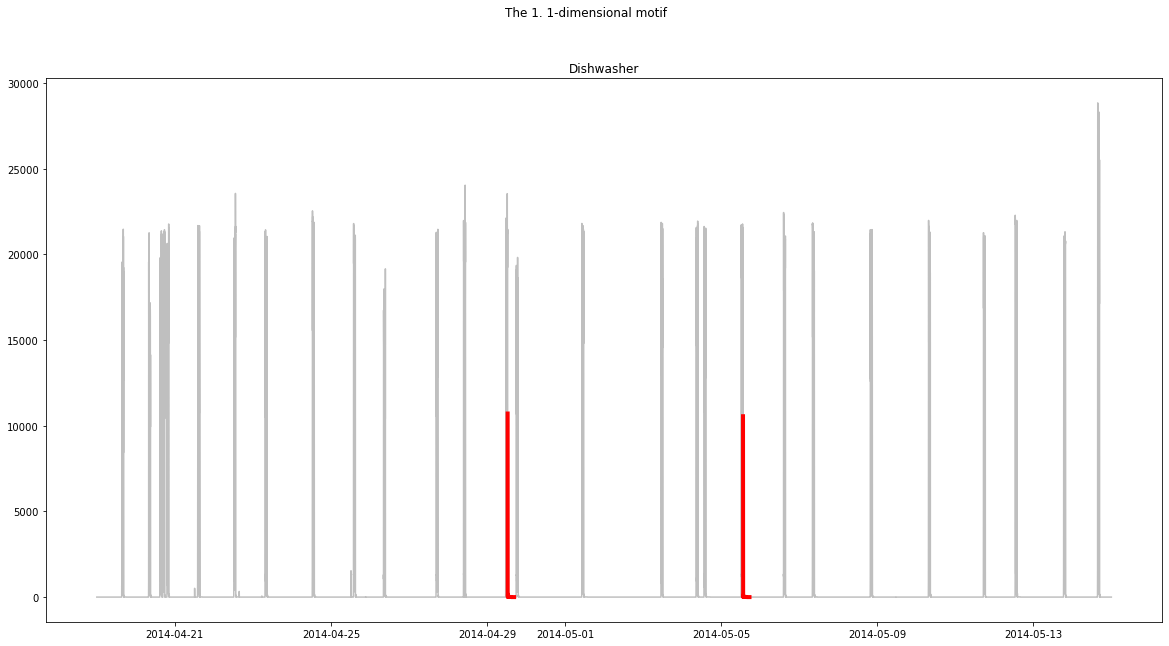

In [13]:
motifs_distances, motifs_indices, motifs_subspaces, motifs_mdls = stumpy.mmotifs(
    df, corrected_mps, indices, max_matches=2
)
show_motifs_matches(df, motifs_distances, motifs_indices, motifs_subspaces, motifs_mdls)

Analogously, if you want to find the motif pair with its three nearest neighbors you will need to set `max_matches=5`!
Tip: If you also set the maximal distance that is allowed between a motif and all other subsequences in the time series to _infinity_ (i. e. numpy.inf), you can make sure that you always get _exactly_ 5 matches (even though this is not necessary here since we were already able to find 10 matches)! So let's see how this works:

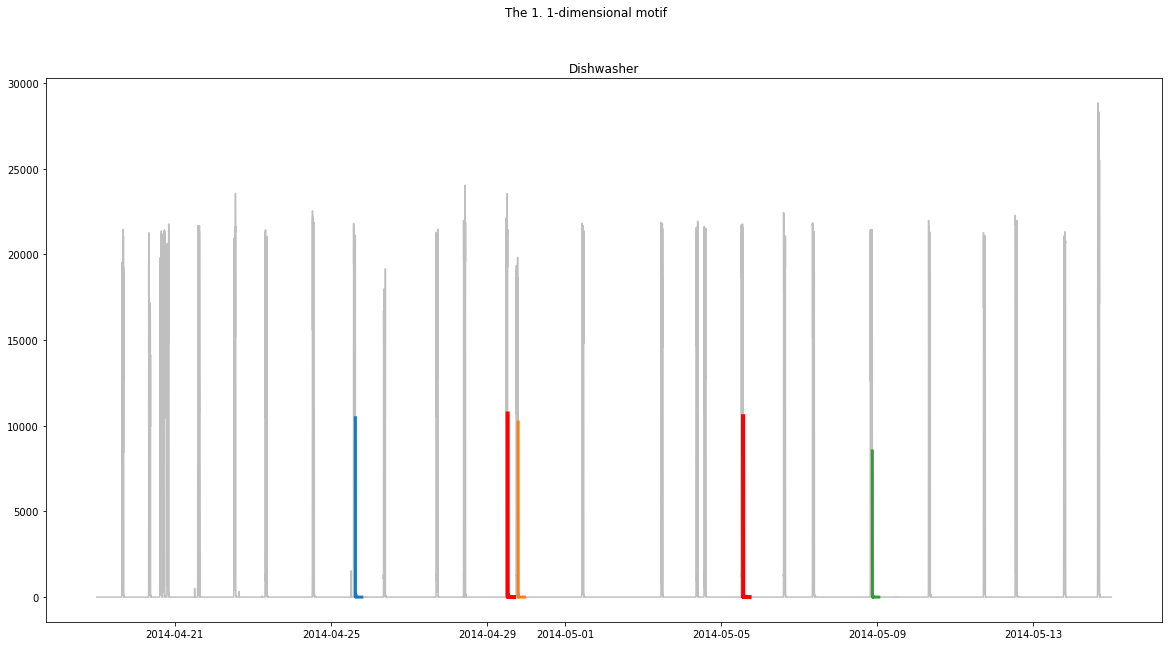

In [14]:
motifs_distances, motifs_indices, motifs_subspaces, motifs_mdls = stumpy.mmotifs(
    df, corrected_mps, indices, max_distance=np.inf, max_matches=5
)
show_motifs_matches(df, motifs_distances, motifs_indices, motifs_subspaces, motifs_mdls)

But why did we find the motif and its neighbors only in one dimension - the `Dishwasher` dimension? Since we were doing an `unconstrained search` (we didn't tell the `mmotifs` function in how many dimensions to search for the motif and what dimensions to search in) the `mmotifs` function is using the `Minmum Description Length (MDL)` approach (as explained in [multidimensional motif discovery tutorial](https://stumpy.readthedocs.io/en/latest/Tutorial_Multidimensional_Motif_Discovery.html)) in order to find the number `k` of dimensions in which the motif is present. To understand why the motif was found in only one dimension we will take a look at the corresponding MDL plot:

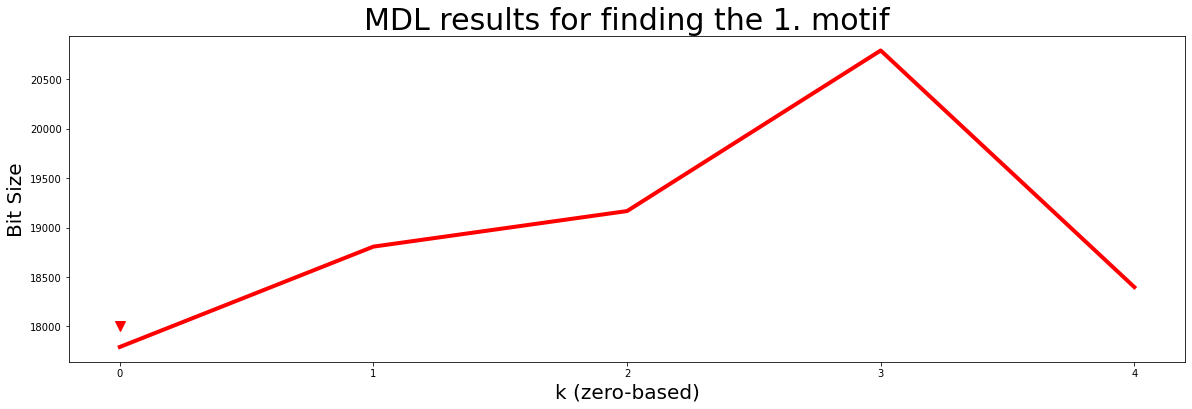

In [15]:
num_motifs = motifs_distances.shape[0]

for motif_num in range(num_motifs):
    mdl = motifs_mdls[motif_num]

    # Plot MDL results
    plt.figure()
    plt.plot(np.arange(len(mdl)), mdl, c='red', linewidth="4")
    plt.title(f"MDL results for finding the {motif_num + 1}. motif", fontsize="30")
    plt.xlabel("k (zero-based)", fontsize="20")
    plt.ylabel("Bit Size", fontsize="20")
    plt.xticks(range(corrected_mps.shape[0]))
    plt.plot(0, 18000, marker="v", markersize=10, color='red')

As we can see the `mmotifs` function selected the optimal number of dimensions automatically for us! Here the data gets compressed the most for `k=0` - i.e. in one dimension. As before we don't want to blindly trust the `mmotifs` results without a reality check. So let's see if it is really the `Dishwasher` dimension that gives the minimum compression size.

In [16]:
num_motifs = motifs_distances.shape[0]

for motif_num in range(num_motifs):
    S = motifs_subspaces[motif_num]
    subspace = [df.columns.values[s] for s in S]
    print(subspace)

['Dishwasher']


And it really seems to be the `Dishwasher` dimenison in which our one-dimensional motif is present! Thus the `mmotifs` function seems to do a good job! So from now on we will trust the judgement of `mmotifs` so we don't have to check the MDL plot and the found subspace manually every time.

## Discovering motifs in multiple dimensions by specifying the number of relevant dimensions

Because we are interested in finding truly multidimensional motifs, we have to specify in how many dimensions the `mmotifs` function should look for the most similar subsequences. Otherwise we would be limited to finding one-dimensional motifs only. For this purpose the input parameter `k` of the `mmotifs` function is used. The parameter gives the function the number of dimensions (`k+1`, since zero-based) required for discovering the motifs with the desired dimensionality. So let's try to find a motif in two dimensions:

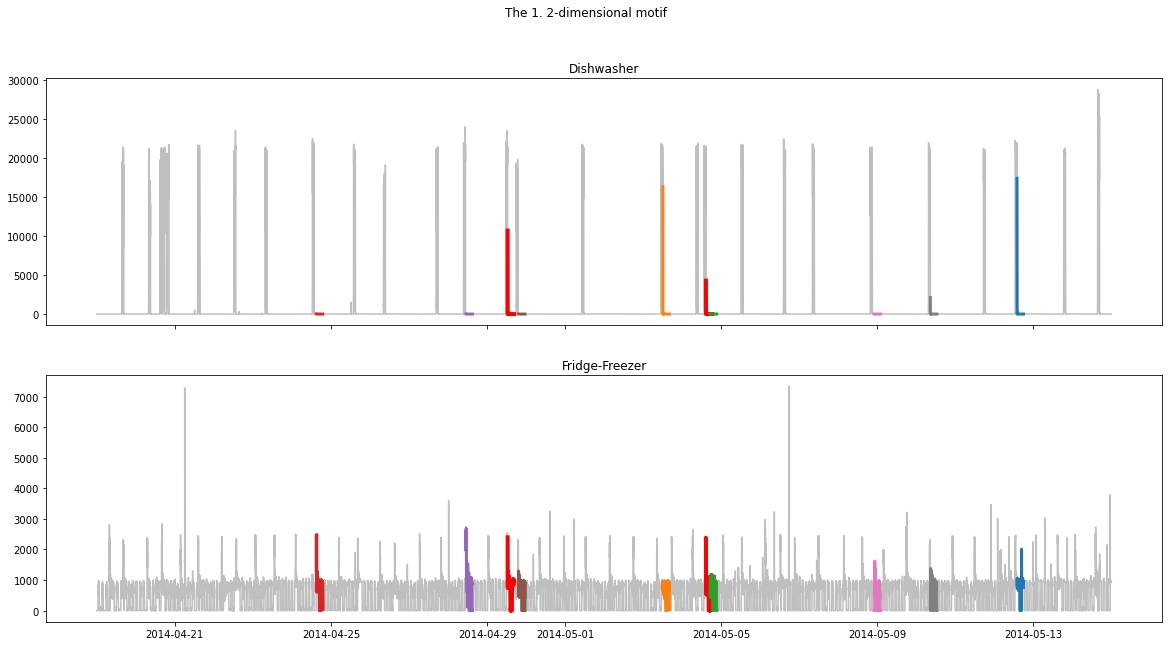

In [17]:
motifs_distances, motifs_indices, motifs_subspaces, motifs_mdls = stumpy.mmotifs(
    df, corrected_mps, indices, k=1
)
show_motifs_matches(df, motifs_distances, motifs_indices, motifs_subspaces, motifs_mdls)

Congratulations! You have found your first two-dimensional motif with its nearest neighbors! The relevant dimensions are the electrical load measurements of the `Dishwasher` and the `Fridge-Freezer`. Since both appliances are commonly used in succession within a relativly short time period (before cooking the food is taken out of the fridge and after cooking the dishes are washed), the found two-dimensional motif makes sense.

## Finding multiple multi-dimensional motifs

So far, we have only ever found a single motif. This is due to the `max_motifs` parameter of the `mmotifs` function which defines the maximum number of motifs to return. If not set otherwise the parameter defaults to `max_motifs=1`. This means that we have to set this parameter explicitly if we want to find multiple multidimensional motifs. Let us, for example, try to find two two-dimensional motifs!

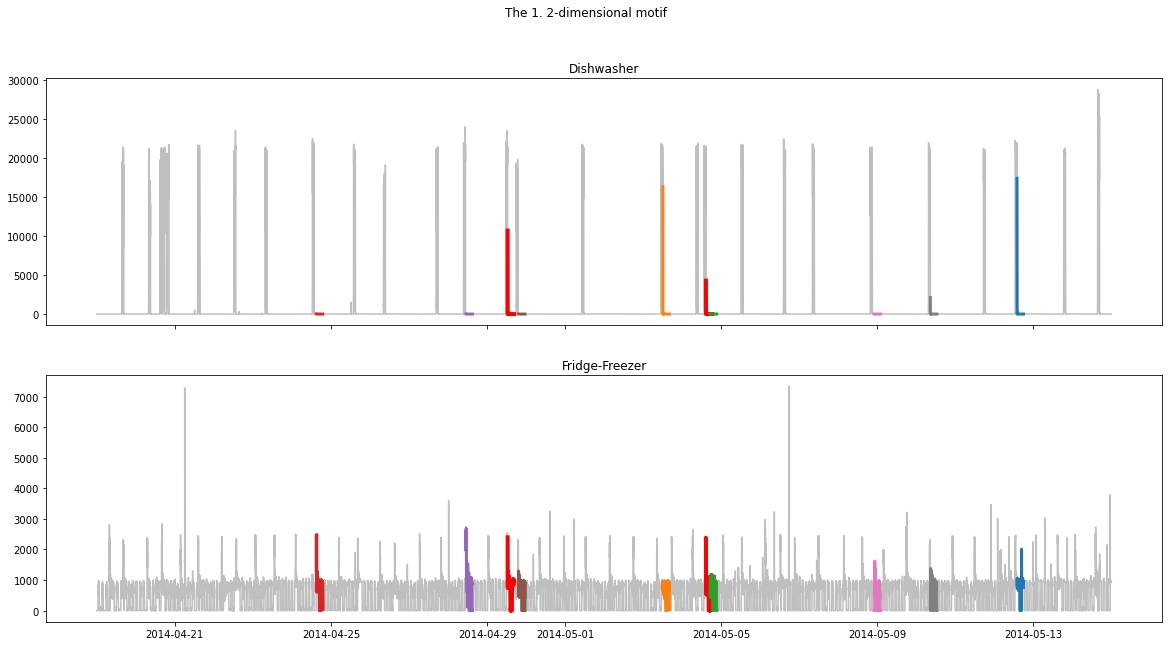

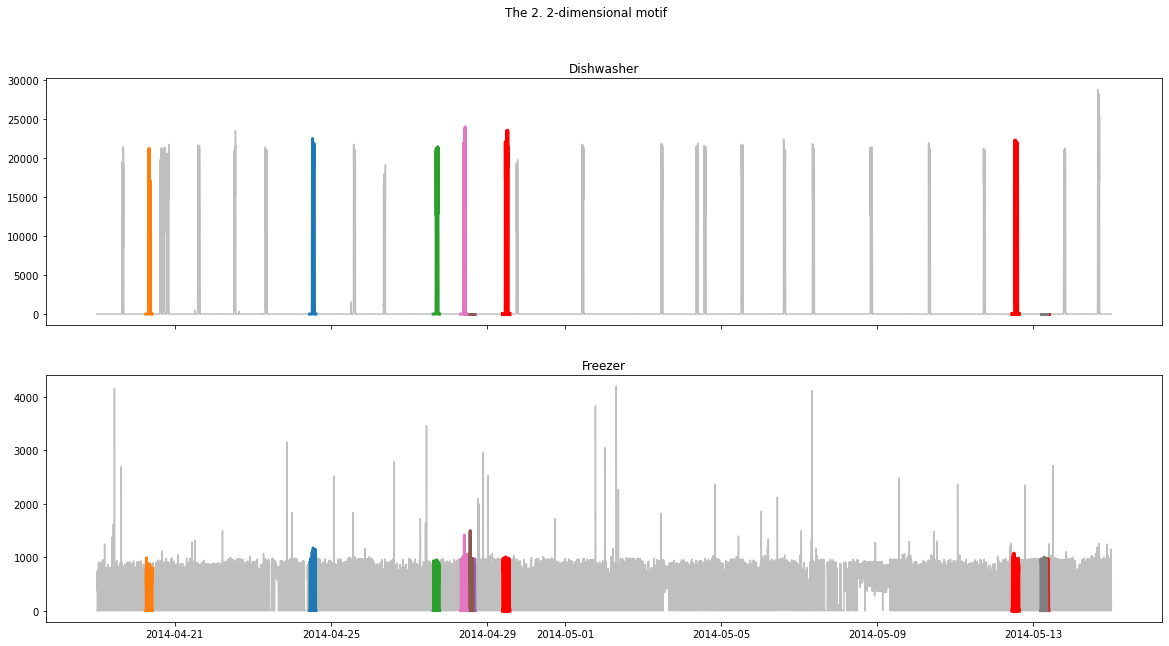

In [18]:
motifs_distances, motifs_indices, motifs_subspaces, motifs_mdls = stumpy.mmotifs(
    df, corrected_mps, indices, max_motifs=2, k=1
)
show_motifs_matches(df, motifs_distances, motifs_indices, motifs_subspaces, motifs_mdls)

And just as expected, we get the top-2 multidimensional motifs with their `max_matches` nearest neighbors. The first two-dimensional motif is, of course, the same one we found in the last section. Our second motif, however, has been unknown. As you can see it extends over the dimensions of the `Dishwasher` and the `Freezer`.



## Constrained Search

The only dimensions in which we have not yet been able to find a motif are that of the `Tumble Dryer` and `Washing Machine`. Let's see if we can also find significant motifs spanning this time series dimensions! To do so we can use the `include` parameter that is also known from the [multidimensional motif discovery tutorial](https://stumpy.readthedocs.io/en/latest/Tutorial_Multidimensional_Motif_Discovery.html). When leveraging the `include` parameter we are able to find the best `k`-dimensional motif while enforcing the utilization of the `Tumble Dryer` and `Washing Machine` dimensions.

Remember: If you use the `include` (or `exclude`) parameter to ensure that specific time series dimensions are included (or excluded) when searching for the best multi-dimensional motif, you also have to set the `include` parameter when computing the multi-dimensional matrix profile. This is because the matrix profile may have to prioritize less important dimensions here so that motifs can also be found in dimensions which wouldn't be discovered when computing the matrix profile normally.

Accordingly, we first calculate the "include-specific" multi-dimensional matrix profile to search for a motif in the - often used directly after each other - `Tumble Dryer` and `Washing Machine` dimensions:

In [19]:
mps, indices = stumpy.mstump(df, m, include=[2, 4])
corrected_mps = mps + ((1.0 - annotation_vector) * np.max(mps))

Since we have recomputed the multi-dimensional matrix profile in order to prioritize the `Tumble Dryer` and `Washing Machine`, we can now call `mmotifs` again and plot the results. Here, the `include` parameter needs to be set again!

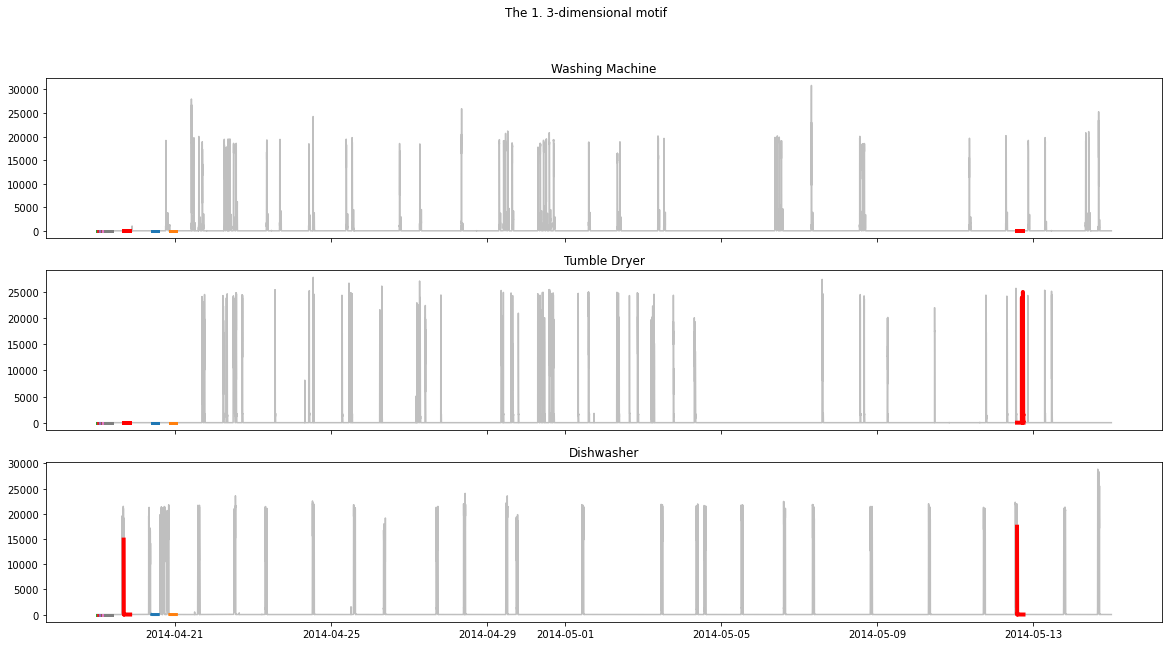

In [20]:
motifs_distances, motifs_indices, motifs_subspaces, motifs_mdls = stumpy.mmotifs(
    df, corrected_mps, indices, include=[2, 4]
)
show_motifs_matches(df, motifs_distances, motifs_indices, motifs_subspaces, motifs_mdls)

When searching for the best motif on `k` dimensions while explicitly including the `Tumble Dryer` and `Washing Machine`, we get a 3-dimensional motif spanning the dimensions of the `Washing Machine`, `Tumble Dryer` and `Dishwasher`. We only set the `include` parameter explicitly and used default values for the rest of the multi-dimensional motif search. The significance of the motifs found is questionable since many regions without an electircal power demand are found.

### <font color='red'>These results are neither sufficiently obvious nor conclusive enough for a tutorial and should be replaced with something more eye-catching and easily comprehensible. Nonetheless the usage of the `mmotifs` function was demonstrated.</font>